TV-Regularized Sparse-View CT Reconstruction (Multiple Projectors)
==================================================================

This example demonstrates solution of a sparse-view CT reconstruction
problem with isotropic total variation (TV) regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + \lambda \| C \mathbf{x} \|_{2,1} \;,$$

where $A$ is the X-ray transform (the CT forward projection operator),
$\mathbf{y}$ is the sinogram, $C$ is a 2D finite difference operator, and
$\mathbf{x}$ is the desired image. The solution is computed and compared
for all three 2D CT projectors available in scico, using a sinogram
computed with the astra projector.

In [1]:
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install git+https://github.com/lanl/scico
!pip install astra-toolbox xdesign

import numpy as np

from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.linop.xray import XRayTransform2D, astra, svmbir
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 512  # phantom size
np.random.seed(1234)
x_gt = snp.array(discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N))

Define CT geometry and construct array of (approximately) equivalent projectors.

In [3]:
n_projection = 45  # number of projections
angles = np.linspace(0, np.pi, n_projection, endpoint=False)  # evenly spaced projection angles
det_count = int(N * 1.05 / np.sqrt(2.0))
det_spacing = np.sqrt(2)
projectors = {
    "astra": astra.XRayTransform2D(
        x_gt.shape, det_count, det_spacing, angles - np.pi / 2.0
    ),  # astra
    "svmbir": svmbir.XRayTransform(
        x_gt.shape, 2 * np.pi - angles, det_count, delta_pixel=1.0, delta_channel=det_spacing
    ),  # svmbir
    "scico": XRayTransform2D((N, N), angles, det_count=det_count, dx=1 / det_spacing),  # scico
}

Compute common sinogram using astra projector.

In [4]:
A = projectors["astra"]
noise = np.random.normal(size=(n_projection, det_count)).astype(np.float32)
y = A @ x_gt + 2.0 * noise

Construct initial solution for regularized problem.

In [5]:
x0 = A.fbp(y)

Solve the same problem using the different projectors.

In [6]:
print(f"Solving on {device_info()}")
x_rec, hist = {}, {}
for p in projectors.keys():
    print(f"\nSolving with {p} projector")

    # Set up ADMM solver object.
    λ = 2e1  # L1 norm regularization parameter
    ρ = 1e3  # ADMM penalty parameter
    maxiter = 100  # number of ADMM iterations
    cg_tol = 1e-4  # CG relative tolerance
    cg_maxiter = 50  # maximum CG iterations per ADMM iteration

    # The append=0 option makes the results of horizontal and vertical
    # finite differences the same shape, which is required for the L21Norm,
    # which is used so that g(Cx) corresponds to isotropic TV.
    C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
    g = λ * functional.L21Norm()
    A = projectors[p]
    f = loss.SquaredL2Loss(y=y, A=A)

    # Set up the solver.
    solver = ADMM(
        f=f,
        g_list=[g],
        C_list=[C],
        rho_list=[ρ],
        x0=x0,
        maxiter=maxiter,
        subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": cg_tol, "maxiter": cg_maxiter}),
        itstat_options={"display": True, "period": 5},
    )

    # Run the solver.
    solver.solve()
    hist[p] = solver.itstat_object.history(transpose=True)
    x_rec[p] = solver.x

    if p == "scico":
        x_rec[p] = x_rec[p] * det_spacing  # to match ASTRA's scaling

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)

Solving with astra projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  4.34e+00  2.882e+06  3.234e+02  3.891e+04     28  7.135e-05


   5  1.26e+01  7.071e+05  5.774e+01  1.926e+04     12  9.685e-05


  10  2.00e+01  3.556e+05  5.925e+01  1.001e+04     14  9.346e-05


  15  2.78e+01  2.880e+05  3.673e+01  4.758e+03     13  9.387e-05


  20  3.44e+01  2.721e+05  2.110e+01  2.504e+03     11  8.890e-05


  25  4.01e+01  2.666e+05  1.322e+01  1.553e+03      7  9.818e-05


  30  4.45e+01  2.640e+05  8.747e+00  1.126e+03      6  9.464e-05


  35  4.85e+01  2.625e+05  6.350e+00  9.087e+02      5  9.423e-05


  40  5.15e+01  2.616e+05  5.191e+00  7.200e+02      4  9.547e-05


  45  5.43e+01  2.610e+05  3.830e+00  6.485e+02      4  9.716e-05


  50  5.70e+01  2.605e+05  2.935e+00  5.761e+02      3  9.932e-05


  55  5.95e+01  2.601e+05  2.344e+00  5.210e+02      3  8.713e-05


  60  6.19e+01  2.598e+05  2.205e+00  4.681e+02      3  8.723e-05


  65  6.39e+01  2.596e+05  2.479e+00  4.053e+02      2  9.819e-05


  70  6.59e+01  2.594e+05  2.649e+00  3.238e+02      1  9.412e-05


  75  6.79e+01  2.592e+05  2.067e+00  3.516e+02      2  9.190e-05


  80  6.98e+01  2.591e+05  2.776e+00  2.785e+02      2  9.461e-05


  85  7.19e+01  2.590e+05  2.685e+00  2.585e+02      2  8.997e-05


  90  7.41e+01  2.589e+05  2.587e+00  2.458e+02      2  8.917e-05


  95  7.59e+01  2.588e+05  2.268e+00  2.437e+02      2  8.612e-05


  99  7.73e+01  2.588e+05  2.186e+00  2.370e+02      2  8.412e-05

Solving with svmbir projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  1.81e+01  2.428e+06  3.234e+02  3.682e+04     23  9.926e-05


   5  7.82e+01  7.055e+05  5.333e+01  1.864e+04     11  9.773e-05


  10  1.35e+02  3.847e+05  5.653e+01  1.024e+04     13  9.074e-05


  15  1.87e+02  3.058e+05  3.704e+01  5.165e+03     12  9.418e-05


  20  2.34e+02  2.837e+05  2.264e+01  2.808e+03     10  9.474e-05


  25  2.73e+02  2.756e+05  1.423e+01  1.751e+03      8  9.431e-05


  30  3.08e+02  2.718e+05  9.402e+00  1.264e+03      7  9.232e-05


  35  3.36e+02  2.697e+05  7.120e+00  9.897e+02      5  9.792e-05


  40  3.58e+02  2.685e+05  5.457e+00  8.117e+02      5  9.245e-05


  45  3.77e+02  2.676e+05  4.120e+00  6.941e+02      3  9.976e-05


  50  3.96e+02  2.669e+05  3.253e+00  6.182e+02      3  9.845e-05


  55  4.14e+02  2.665e+05  3.225e+00  5.480e+02      4  8.411e-05


  60  4.31e+02  2.661e+05  2.202e+00  5.118e+02      3  8.856e-05


  65  4.48e+02  2.657e+05  2.096e+00  4.645e+02      3  8.269e-05


  70  4.64e+02  2.655e+05  1.859e+00  4.355e+02      2  9.972e-05


  75  4.78e+02  2.653e+05  2.558e+00  3.650e+02      2  9.422e-05


  80  4.93e+02  2.651e+05  2.851e+00  3.052e+02      2  9.458e-05


  85  5.07e+02  2.650e+05  2.729e+00  2.895e+02      2  9.593e-05


  90  5.22e+02  2.649e+05  2.633e+00  2.705e+02      2  8.872e-05


  95  5.36e+02  2.648e+05  2.547e+00  2.584e+02      2  8.931e-05


  99  5.46e+02  2.647e+05  2.294e+00  1.797e+02      1  9.133e-05

Solving with scico projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  2.03e-01  2.902e+06  3.233e+02  5.526e+04     22  9.715e-05


   5  4.85e-01  5.083e+05  6.554e+01  1.878e+04     11  8.384e-05


  10  7.42e-01  2.649e+05  5.835e+01  8.844e+03     13  8.544e-05


  15  9.76e-01  2.187e+05  3.326e+01  4.083e+03     10  9.636e-05


  20  1.18e+00  2.068e+05  1.882e+01  2.186e+03      8  9.347e-05


  25  1.34e+00  2.025e+05  1.166e+01  1.433e+03      6  9.808e-05
  30  1.49e+00  2.004e+05  7.707e+00  1.043e+03      5  9.235e-05


  35  1.60e+00  1.993e+05  6.075e+00  7.932e+02      1  9.896e-05
  40  1.71e+00  1.985e+05  4.817e+00  6.602e+02      1  8.782e-05


  45  1.81e+00  1.980e+05  3.142e+00  6.465e+02      3  9.023e-05
  50  1.91e+00  1.976e+05  2.983e+00  5.539e+02      3  9.094e-05


  55  2.01e+00  1.973e+05  2.893e+00  3.960e+02      2  9.795e-05
  60  2.10e+00  1.971e+05  2.703e+00  3.474e+02      2  8.545e-05


  65  2.18e+00  1.969e+05  3.179e+00  2.942e+02      2  8.844e-05
  70  2.27e+00  1.968e+05  3.248e+00  2.603e+02      2  7.188e-05
  75  2.35e+00  1.967e+05  3.142e+00  2.432e+02      2  7.820e-05


  80  2.44e+00  1.966e+05  3.028e+00  2.216e+02      2  6.697e-05
  85  2.52e+00  1.965e+05  2.918e+00  2.098e+02      2  7.198e-05


  90  2.60e+00  1.965e+05  2.678e+00  1.963e+02      2  6.400e-05
  95  2.67e+00  1.964e+05  2.207e+00  1.477e+02      1  9.423e-05
  99  2.73e+00  1.963e+05  2.159e+00  1.411e+02      1  9.126e-05


Compare reconstruction results.

In [7]:
print("Reconstruction SNR:")
for p in projectors.keys():
    print(f"  {(p + ':'):7s}  {metric.snr(x_gt, x_rec[p]):5.2f} dB")

Reconstruction SNR:


  astra:   10.98 dB
  svmbir:  11.10 dB
  scico:   10.97 dB


Display sinogram.

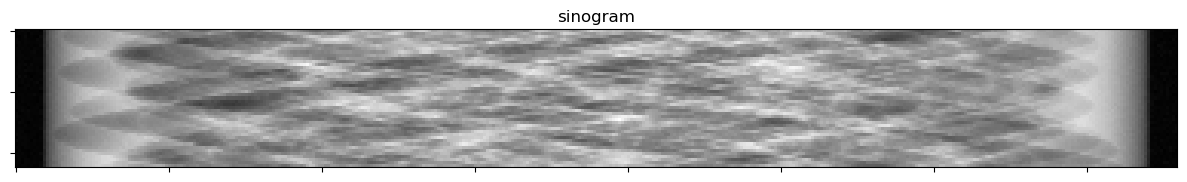

In [8]:
fig, ax = plot.subplots(nrows=1, ncols=1, figsize=(15, 3))
plot.imview(y, title="sinogram", fig=fig, ax=ax)
fig.show()

Plot convergence statistics.

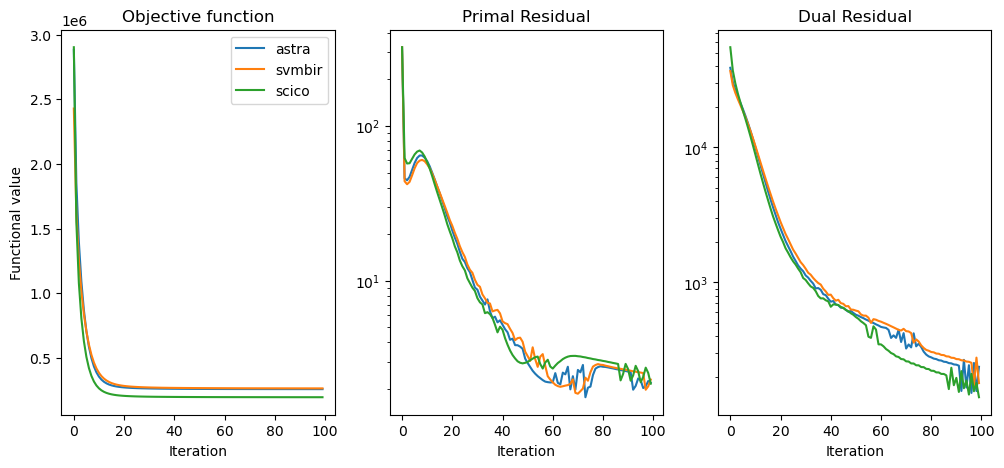

In [9]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(12, 5))
plot.plot(
    np.vstack([hist[p].Objective for p in projectors.keys()]).T,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    lgnd=projectors.keys(),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    np.vstack([hist[p].Prml_Rsdl for p in projectors.keys()]).T,
    ptyp="semilogy",
    title="Primal Residual",
    xlbl="Iteration",
    fig=fig,
    ax=ax[1],
)
plot.plot(
    np.vstack([hist[p].Dual_Rsdl for p in projectors.keys()]).T,
    ptyp="semilogy",
    title="Dual Residual",
    xlbl="Iteration",
    fig=fig,
    ax=ax[2],
)
fig.show()

Show the recovered images.

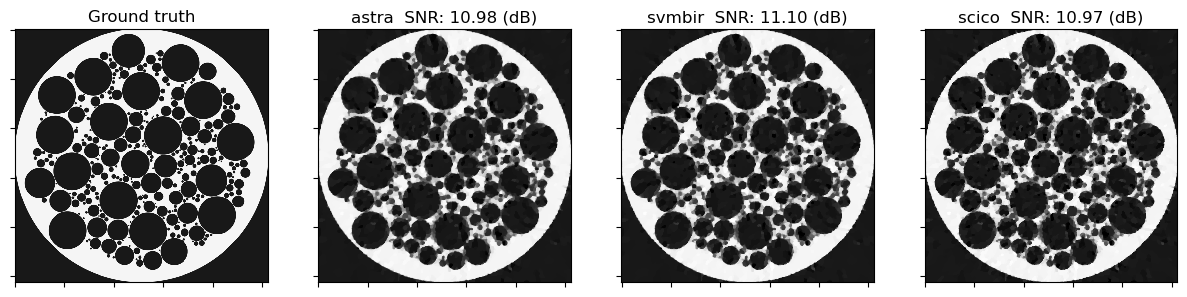

In [10]:
fig, ax = plot.subplots(nrows=1, ncols=4, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
for n, p in enumerate(projectors.keys()):
    plot.imview(
        x_rec[p],
        title="%s  SNR: %.2f (dB)" % (p, metric.snr(x_gt, x_rec[p])),
        fig=fig,
        ax=ax[n + 1],
    )
for ax in ax:
    ax.get_images()[0].set_clim(-0.1, 1.1)
fig.show()